# Financial Machine Learning Recipe Steps Demo

This notebook demonstrates the **financial ML recipe steps** based on "Advances in Financial Machine Learning" by Marcos López de Prado:

1. **StepFractionalDiff**: Fractional differentiation for stationarity while preserving memory
2. **StepVolatilityEWM**: Exponentially weighted moving volatility
3. **StepPermutationEntropy**: Permutation entropy for complexity measurement
4. **StepWeightTimeDecay**: Time decay weighting for observations

## Key Concepts:
- **Fractional Differentiation**: Achieves stationarity while preserving long-term memory (alternative to integer differencing)
- **EWM Volatility**: More responsive volatility estimation using exponentially weighted moving averages
- **Permutation Entropy**: Measures complexity and predictability of time series patterns
- **Time Decay Weighting**: Assigns higher weights to recent observations for adaptive modeling

These steps are designed for financial time series analysis and algorithmic trading applications.


In [16]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from py_workflows import workflow
from py_recipes import recipe
from py_recipes.steps import (
    StepFractionalDiff,
    StepVolatilityEWM,
    StepPermutationEntropy,
    StepWeightTimeDecay
)
from py_parsnip import linear_reg, rand_forest
from py_rsample import initial_time_split, training, testing
from py_yardstick import rmse, mae, r_squared

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('default')
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3

plt.rcParams['figure.figsize'] = (12, 6)


## 1. Generate Synthetic Financial Time Series Data

We'll create realistic stock price data with:
- **Trend**: Long-term upward trend
- **Volatility clustering**: Periods of high and low volatility
- **Mean reversion**: Some autocorrelation
- **Noise**: Random market fluctuations

In [17]:
# Generate 3 years of daily stock price data
n_days = 750
start_date = datetime(2020, 1, 1)

dates = pd.date_range(start=start_date, periods=n_days, freq='D')

# Create realistic price series with volatility clustering
np.random.seed(42)
returns = np.zeros(n_days)
volatility = np.zeros(n_days)
volatility[0] = 0.02  # Initial volatility (2% daily)

# Generate returns with volatility clustering (GARCH-like)
for i in range(1, n_days):
    # Volatility follows mean-reverting process
    volatility[i] = 0.01 + 0.85 * volatility[i-1] + 0.1 * abs(returns[i-1]) + 0.05 * np.random.randn()
    volatility[i] = max(0.005, min(0.05, volatility[i]))  # Bound volatility
    
    # Returns with some autocorrelation and volatility
    returns[i] = 0.0003 + 0.1 * returns[i-1] + volatility[i] * np.random.randn()

# Convert returns to prices (starting at $100)
prices = 100 * np.exp(np.cumsum(returns))

# Create DataFrame
data = pd.DataFrame({
    'date': dates,
    'price': prices,
    'returns': returns,
    'volatility': volatility
})

print(f"Data shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")
print(f"\nPrice statistics:")
print(data['price'].describe())
print(f"\nReturns statistics:")
print(data['returns'].describe())
data.head(10)


Data shape: (750, 4)
Date range: 2020-01-01 00:00:00 to 2022-01-19 00:00:00

Price statistics:
count    750.000000
mean     181.893205
std       61.805665
min       72.858360
25%      142.018303
50%      164.929348
75%      219.239763
max      435.322027
Name: price, dtype: float64

Returns statistics:
count    750.000000
mean       0.001961
std        0.038895
min       -0.143750
25%       -0.014582
50%        0.000852
75%        0.018450
max        0.195039
Name: returns, dtype: float64


,date,price,returns,volatility
0,2020-01-01,100.000000,0.000000,0.020000
1,2020-01-02,99.340860,-0.006613,0.050000
2,2020-01-03,107.162582,0.075790,0.050000
3,2020-01-04,106.793882,-0.003447,0.048371
4,2020-01-05,110.966430,0.038327,0.050000
5,2020-01-06,113.430284,0.021961,0.032859
6,2020-01-07,112.819351,-0.005401,0.016955
7,2020-01-08,105.073533,-0.071127,0.037050
8,2020-01-09,104.067137,-0.009624,0.005000
9,2020-01-10,104.161758,0.000909,0.005000


## 2. Visualize the Data

Let's plot the price series and returns to understand the data characteristics.


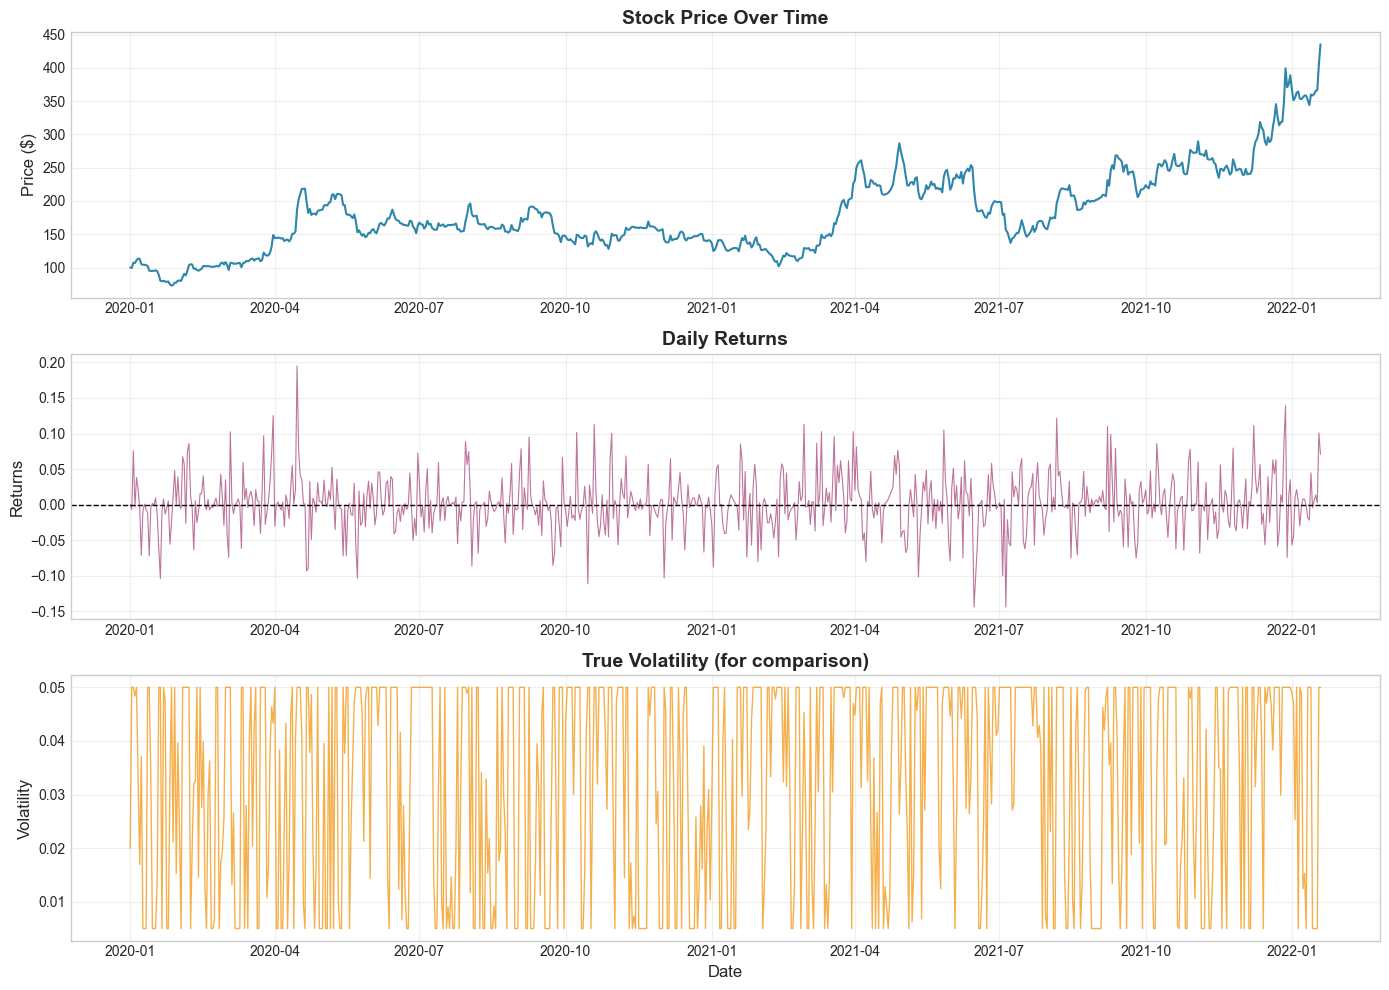

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Price series
axes[0].plot(data['date'], data['price'], linewidth=1.5, color='#2E86AB')
axes[0].set_title('Stock Price Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Returns
axes[1].plot(data['date'], data['returns'], linewidth=0.8, color='#A23B72', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Daily Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Returns', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Volatility
axes[2].plot(data['date'], data['volatility'], linewidth=1, color='#F18F01', alpha=0.7)
axes[2].set_title('True Volatility (for comparison)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Volatility', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Train/Test Split

For time series, we split chronologically to preserve temporal order.


In [19]:
# Split: Train on first 600 days, test on last 150 days
split = initial_time_split(data, date_column='date', prop=0.8)
train_data = training(split)
test_data = testing(split)

print(f"Train: {train_data.shape[0]} days ({train_data['date'].min()} to {train_data['date'].max()})")
print(f"Test: {test_data.shape[0]} days ({test_data['date'].min()} to {test_data['date'].max()})")


Train: 600 days (2020-01-01 00:00:00 to 2021-08-22 00:00:00)
Test: 150 days (2021-08-23 00:00:00 to 2022-01-19 00:00:00)


## 4. Step 1: Fractional Differentiation

Fractional differentiation achieves stationarity while preserving long-term memory. This is superior to integer differencing for financial data.

**Key Parameters:**
- `d`: Fractional differentiation order (0-1, default: 0.5). Can be None if `auto_d=True`
- `auto_d`: Automatically find optimal d using stationarity tests (default: False)
- `d_range`: Range of d values to test when auto_d=True (default: [0.1, 0.2, ..., 0.9])
- `stationarity_test`: Test to use ('adf' or 'kpss', default: 'adf')
- `alpha`: Significance level for stationarity test (default: 0.05)
- `threshold`: Weight decay threshold for window determination
- `window`: Window size (auto-determined if not specified)

**Auto-d Feature:**
When `auto_d=True`, the step automatically tests different d values and selects the smallest d that makes the series stationary. This maximizes memory preservation while achieving stationarity.


Optimal d value automatically found: 0.200
This d value makes the series stationary while preserving maximum memory.


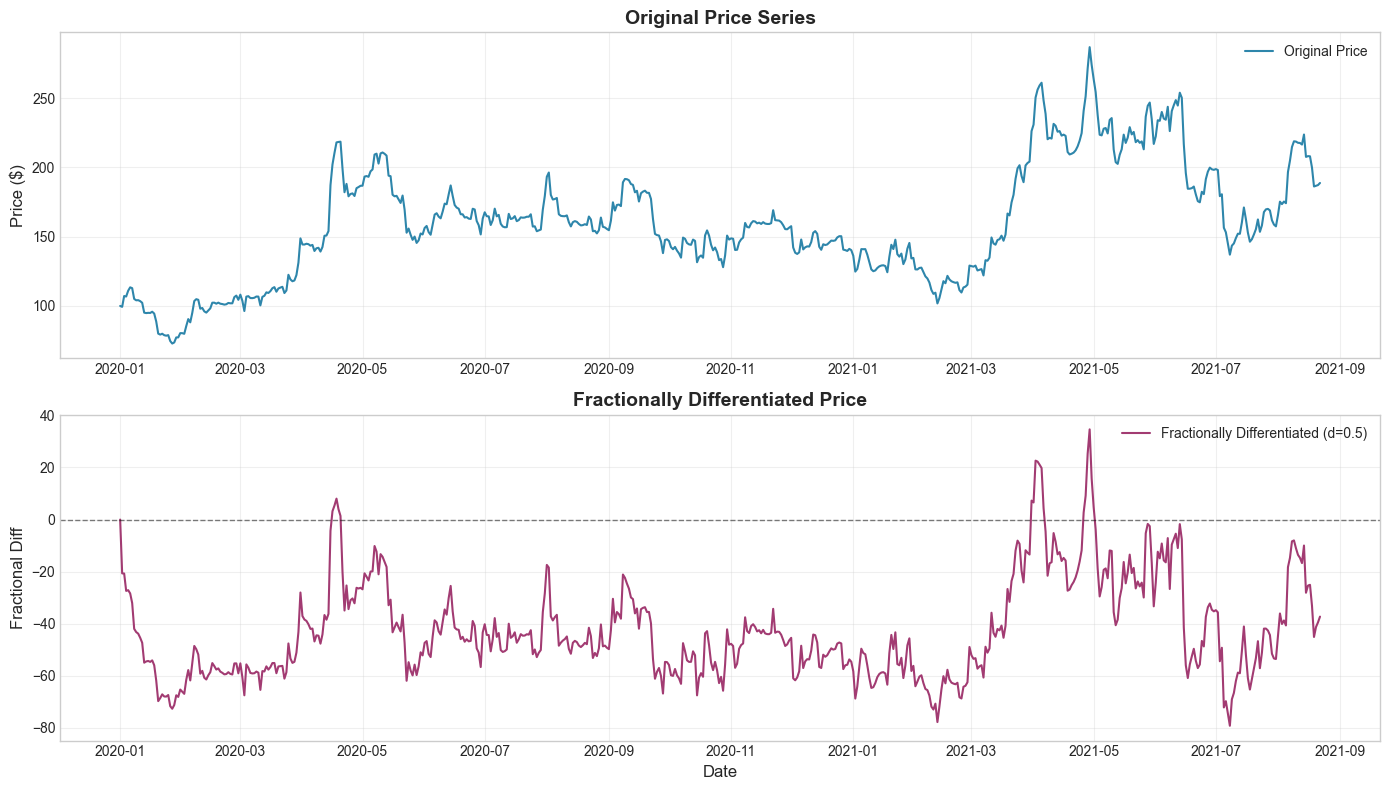


Original price - Mean: 159.85, Std: 40.86
Fractional diff - Mean: -42.6147, Std: 18.7806

New columns created: ['frac_diff_price']


In [20]:
# Option 1: Manual d value
rec_frac_diff_manual = recipe() \
    .step_fractional_diff(
        columns=['price'],
        d=0.5,
        threshold=1e-5,
        date_col='date',
        prefix='frac_diff_manual_'
    ) \
    .step_naomit(columns=['frac_diff_manual_price'])

# Option 2: Auto-calculate optimal d (recommended)
rec_frac_diff = recipe() \
    .step_fractional_diff(
        columns=['price'],
        auto_d=True,  # Automatically find optimal d using stationarity tests
        stationarity_test='adf',
        alpha=0.05,
        threshold=1e-5,
        date_col='date',
        prefix='frac_diff_'
    ) \
    .step_naomit(columns=['frac_diff_price'])  # Remove rows with NaN from fractional diff

# Prepare and bake
prep_frac_diff = rec_frac_diff.prep(train_data)
train_transformed = prep_frac_diff.bake(train_data)
test_transformed = prep_frac_diff.bake(test_data)

# Check the optimal d value that was automatically found
optimal_d = prep_frac_diff.prepared_steps[0].d
print(f"Optimal d value automatically found: {optimal_d:.3f}")
print(f"This d value makes the series stationary while preserving maximum memory.")

# Compare original price vs fractionally differentiated
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original price
axes[0].plot(train_data['date'], train_data['price'], label='Original Price', linewidth=1.5, color='#2E86AB')
axes[0].set_title('Original Price Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Fractionally differentiated
axes[1].plot(train_transformed['date'], train_transformed['frac_diff_price'], 
             label='Fractionally Differentiated (d=0.5)', linewidth=1.5, color='#A23B72')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_title('Fractionally Differentiated Price', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Fractional Diff', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOriginal price - Mean: {train_data['price'].mean():.2f}, Std: {train_data['price'].std():.2f}")
print(f"Fractional diff - Mean: {train_transformed['frac_diff_price'].mean():.4f}, Std: {train_transformed['frac_diff_price'].std():.4f}")
print(f"\nNew columns created: {[col for col in train_transformed.columns if 'frac_diff' in col]}")


## 5. Step 2: Exponentially Weighted Moving Volatility

EWM volatility gives more weight to recent observations, making it more responsive to changing market conditions than simple rolling volatility.

**Key Parameters:**
- `return_col`: Column containing returns (or prices if `use_returns=False`)
- `span`: Span for exponential weighting (default: 20)
- `use_returns`: Whether input is returns (True) or prices (False)


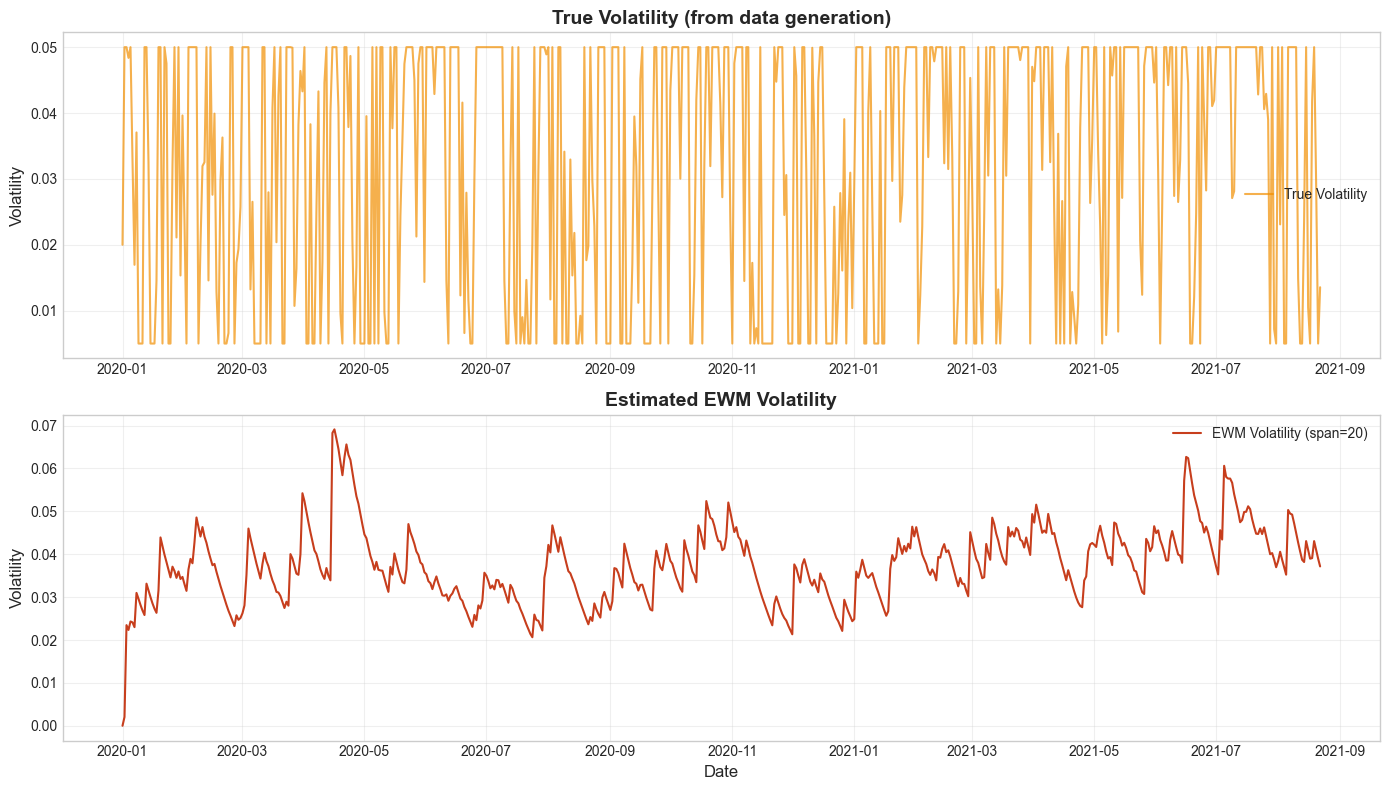


True volatility - Mean: 0.0325, Std: 0.0190
EWM volatility - Mean: 0.0376, Std: 0.0087

New columns created: ['vol_ewm_returns']


In [21]:
# Create recipe with EWM volatility
rec_vol = recipe() \
    .step_volatility_ewm(
        return_col='returns',
        span=20,
        use_returns=True,
        date_col='date',
        prefix='vol_ewm_'
    )

# Prepare and bake
prep_vol = rec_vol.prep(train_data)
train_vol = prep_vol.bake(train_data)
test_vol = prep_vol.bake(test_data)

# Compare true volatility vs EWM volatility
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# True volatility (from data generation)
axes[0].plot(train_data['date'], train_data['volatility'], 
             label='True Volatility', linewidth=1.5, color='#F18F01', alpha=0.7)
axes[0].set_title('True Volatility (from data generation)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Volatility', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# EWM volatility
axes[1].plot(train_vol['date'], train_vol['vol_ewm_returns'], 
             label='EWM Volatility (span=20)', linewidth=1.5, color='#C73E1D')
axes[1].set_title('Estimated EWM Volatility', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatility', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTrue volatility - Mean: {train_data['volatility'].mean():.4f}, Std: {train_data['volatility'].std():.4f}")
print(f"EWM volatility - Mean: {train_vol['vol_ewm_returns'].mean():.4f}, Std: {train_vol['vol_ewm_returns'].std():.4f}")
print(f"\nNew columns created: {[col for col in train_vol.columns if 'vol_ewm' in col]}")


## 6. Step 3: Permutation Entropy

Permutation entropy measures the complexity and predictability of time series by analyzing ordinal patterns. Higher entropy indicates more randomness, lower entropy indicates more structure.

**Key Parameters:**
- `columns`: Columns to calculate entropy for
- `window`: Rolling window (None = full series)
- `order`: Order of permutations (default: 3)
- `normalize`: Whether to normalize entropy (default: True)


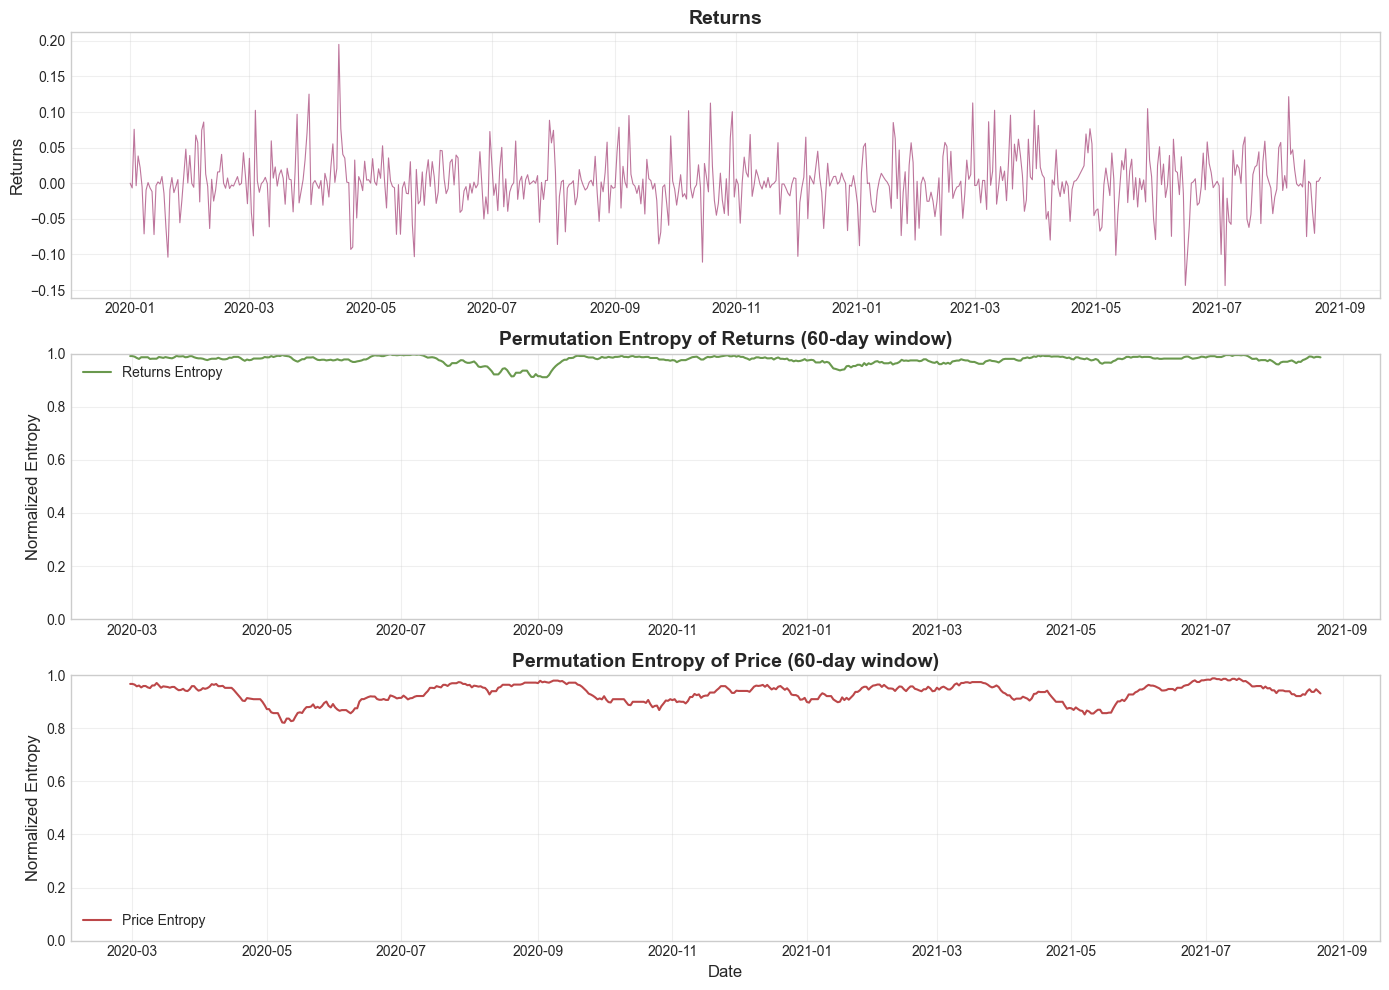


Returns entropy - Mean: 0.9769, Std: 0.0164
Price entropy - Mean: 0.9324, Std: 0.0348

New columns created: ['perm_entropy_returns', 'perm_entropy_price']


In [22]:
# Create recipe with permutation entropy
rec_entropy = recipe() \
    .step_permutation_entropy(
        columns=['returns', 'price'],
        window=60,  # 60-day rolling window
        order=3,
        normalize=True,
        date_col='date',
        prefix='perm_entropy_'
    )

# Prepare and bake
prep_entropy = rec_entropy.prep(train_data)
train_entropy = prep_entropy.bake(train_data)
test_entropy = prep_entropy.bake(test_data)

# Visualize permutation entropy
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Returns
axes[0].plot(train_data['date'], train_data['returns'], linewidth=0.8, color='#A23B72', alpha=0.7)
axes[0].set_title('Returns', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Returns', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Permutation entropy of returns
axes[1].plot(train_entropy['date'], train_entropy['perm_entropy_returns'], 
             linewidth=1.5, color='#6A994E', label='Returns Entropy')
axes[1].set_title('Permutation Entropy of Returns (60-day window)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Normalized Entropy', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Permutation entropy of price
axes[2].plot(train_entropy['date'], train_entropy['perm_entropy_price'], 
             linewidth=1.5, color='#BC4749', label='Price Entropy')
axes[2].set_title('Permutation Entropy of Price (60-day window)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Normalized Entropy', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylim([0, 1])
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReturns entropy - Mean: {train_entropy['perm_entropy_returns'].mean():.4f}, Std: {train_entropy['perm_entropy_returns'].std():.4f}")
print(f"Price entropy - Mean: {train_entropy['perm_entropy_price'].mean():.4f}, Std: {train_entropy['perm_entropy_price'].std():.4f}")
print(f"\nNew columns created: {[col for col in train_entropy.columns if 'perm_entropy' in col]}")


## 7. Step 4: Time Decay Weighting

Time decay weighting assigns higher weights to more recent observations, reflecting the adaptive nature of financial markets. This is useful for training models that should adapt to recent market conditions.

**Key Parameters:**
- `date_col`: Date column for determining observation age
- `decay_rate`: Decay rate (higher = faster decay, default: 0.1)
- `method`: 'linear', 'exponential', or 'piecewise' (default: 'exponential')
- `base_weight`: Base weight for oldest observations (default: 1.0)


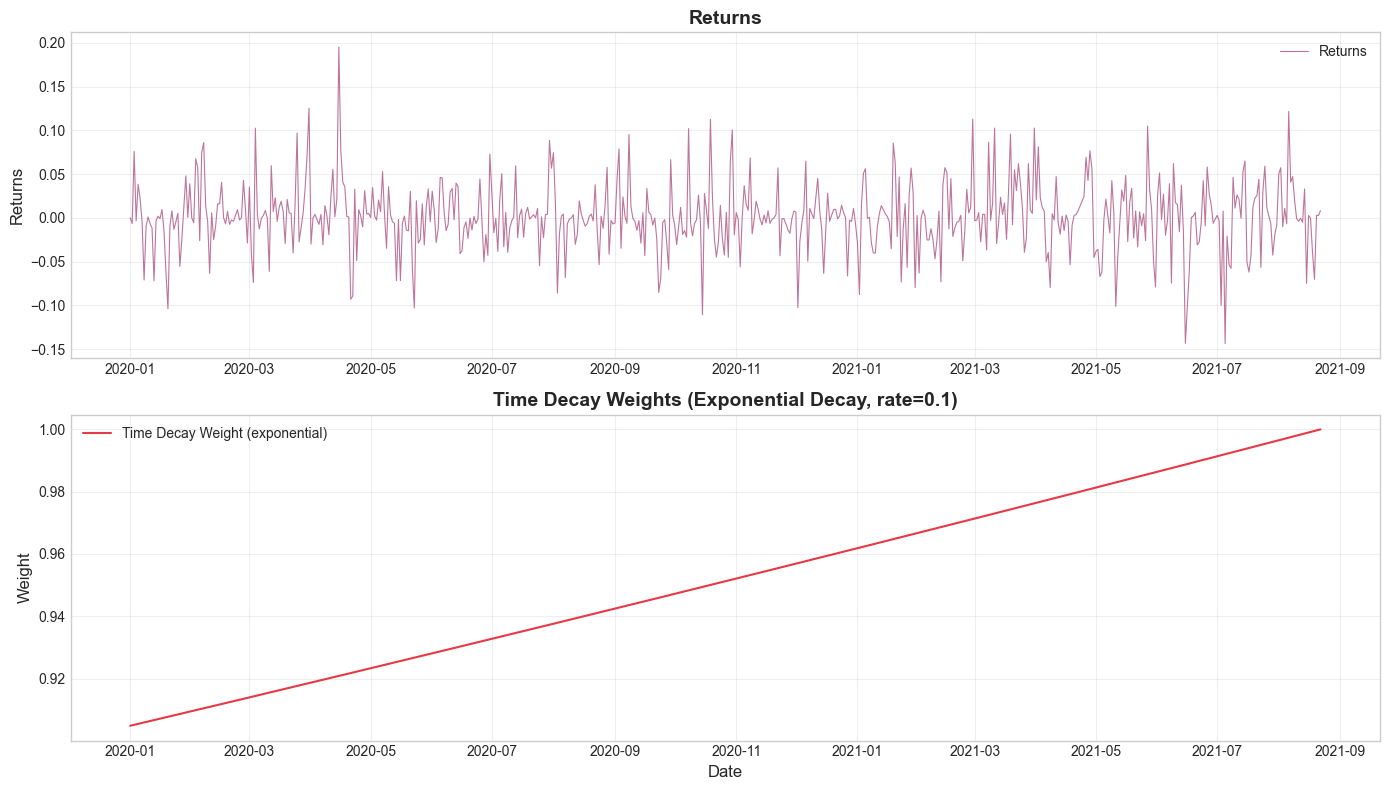


Weight statistics:
count    600.000000
mean       0.951627
std        0.027538
min        0.904837
25%        0.927743
50%        0.951229
75%        0.975310
max        1.000000
Name: weight, dtype: float64

Oldest observation weight: 0.9048
Newest observation weight: 1.0000
Weight ratio (newest/oldest): 1.11x


In [23]:
# Create recipe with time decay weighting
rec_weights = recipe() \
    .step_weight_time_decay(
        date_col='date',
        decay_rate=0.1,
        method='exponential',
        base_weight=1.0,
        weight_col_name='weight'
    )

# Prepare and bake
prep_weights = rec_weights.prep(train_data)
train_weights = prep_weights.bake(train_data)
test_weights = prep_weights.bake(test_data)

# Visualize time decay weights
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Returns
axes[0].plot(train_weights['date'], train_weights['returns'], 
             linewidth=0.8, color='#A23B72', alpha=0.7, label='Returns')
axes[0].set_title('Returns', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Returns', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time decay weights
axes[1].plot(train_weights['date'], train_weights['weight'], 
             linewidth=1.5, color='#E63946', label='Time Decay Weight (exponential)')
axes[1].set_title('Time Decay Weights (Exponential Decay, rate=0.1)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Weight', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nWeight statistics:")
print(train_weights['weight'].describe())
print(f"\nOldest observation weight: {train_weights['weight'].iloc[0]:.4f}")
print(f"Newest observation weight: {train_weights['weight'].iloc[-1]:.4f}")
print(f"Weight ratio (newest/oldest): {train_weights['weight'].iloc[-1] / train_weights['weight'].iloc[0]:.2f}x")


## 8. Combining All Steps in a Workflow

Now let's combine all financial ML steps into a single workflow and use them for modeling.


In [24]:
# Create comprehensive recipe with all financial ML steps
rec_finml = recipe() \
    .step_fractional_diff(
        columns=['price'],
        d=0.5,
        threshold=1e-5,
        date_col='date',
        prefix='frac_diff_'
    ) \
    .step_volatility_ewm(
        return_col='returns',
        span=20,
        use_returns=True,
        date_col='date',
        prefix='vol_ewm_'
    ) \
    .step_permutation_entropy(
        columns=['returns'],
        window=60,
        order=3,
        normalize=True,
        date_col='date',
        prefix='perm_entropy_'
    ) \
    .step_weight_time_decay(
        date_col='date',
        decay_rate=0.1,
        method='exponential',
        base_weight=1.0,
        weight_col_name='weight'
    ) \
    .step_naomit(columns=['frac_diff_price', 'vol_ewm_returns', 'perm_entropy_returns'])  # Remove rows with NaN

# Prepare recipe
prep_finml = rec_finml.prep(train_data)

# Apply to training data
train_finml = prep_finml.bake(train_data)

# Show created features
print("Created Financial ML Features:")
print("=" * 60)
finml_cols = [col for col in train_finml.columns 
              if any(x in col for x in ['frac_diff', 'vol_ewm', 'perm_entropy', 'weight'])]
for col in finml_cols:
    print(f"  - {col}")

print(f"\nTotal features: {len(train_finml.columns)}")
print(f"\nSample of transformed data:")
train_finml[['date', 'price', 'returns'] + finml_cols].head(10)


Created Financial ML Features:
  - frac_diff_price
  - vol_ewm_returns
  - perm_entropy_returns
  - weight

Total features: 8

Sample of transformed data:


,date,price,returns,frac_diff_price,vol_ewm_returns,perm_entropy_returns,weight
59,2020-02-29,104.424713,-0.028750,-92.580635,0.025125,0.991578,0.913794
60,2020-03-01,108.146629,0.035022,-87.860450,0.026229,0.991578,0.913946
61,2020-03-02,103.733050,-0.041667,-94.098254,0.028068,0.989301,0.914099
62,2020-03-03,96.337871,-0.073959,-99.821624,0.035124,0.984381,0.914252
63,2020-03-04,106.728513,0.102427,-85.507113,0.045993,0.980724,0.914404
64,2020-03-05,107.055450,0.003059,-89.417701,0.043759,0.987023,0.914557
65,2020-03-06,105.699445,-0.012747,-91.798918,0.041808,0.987023,0.914710
66,2020-03-07,105.632673,-0.000632,-91.637378,0.039768,0.987023,0.914862
67,2020-03-08,105.908181,0.002605,-91.441571,0.037835,0.987023,0.915015
68,2020-03-09,106.791960,0.008310,-90.810666,0.036080,0.980724,0.915168


## 8.1. Auto-Calculate Optimal d for Fractional Differentiation

The `auto_d` parameter automatically finds the optimal fractional differentiation order `d` that makes the series stationary while preserving maximum memory. This is particularly useful when you're unsure what `d` value to use.

**How it works:**
- Tests different `d` values (default: [0.1, 0.2, ..., 0.9])
- Applies fractional differentiation with each `d`
- Tests for stationarity using ADF or KPSS test
- Selects the **smallest** `d` that makes the series stationary (maximizes memory preservation)


Manual d value: 0.500
Auto-calculated optimal d: 0.200

The auto-calculated d=0.200 makes the series stationary while preserving more memory than d=0.5

Comparison of fractional differentiation results:
Method                    Mean            Std             Min             Max            
----------------------------------------------------------------------
Manual (d=0.5)                -92.082630      10.883431    -125.621229       0.000000
Auto (d=0.2)                  -42.614714      18.780555     -79.158585      34.634937


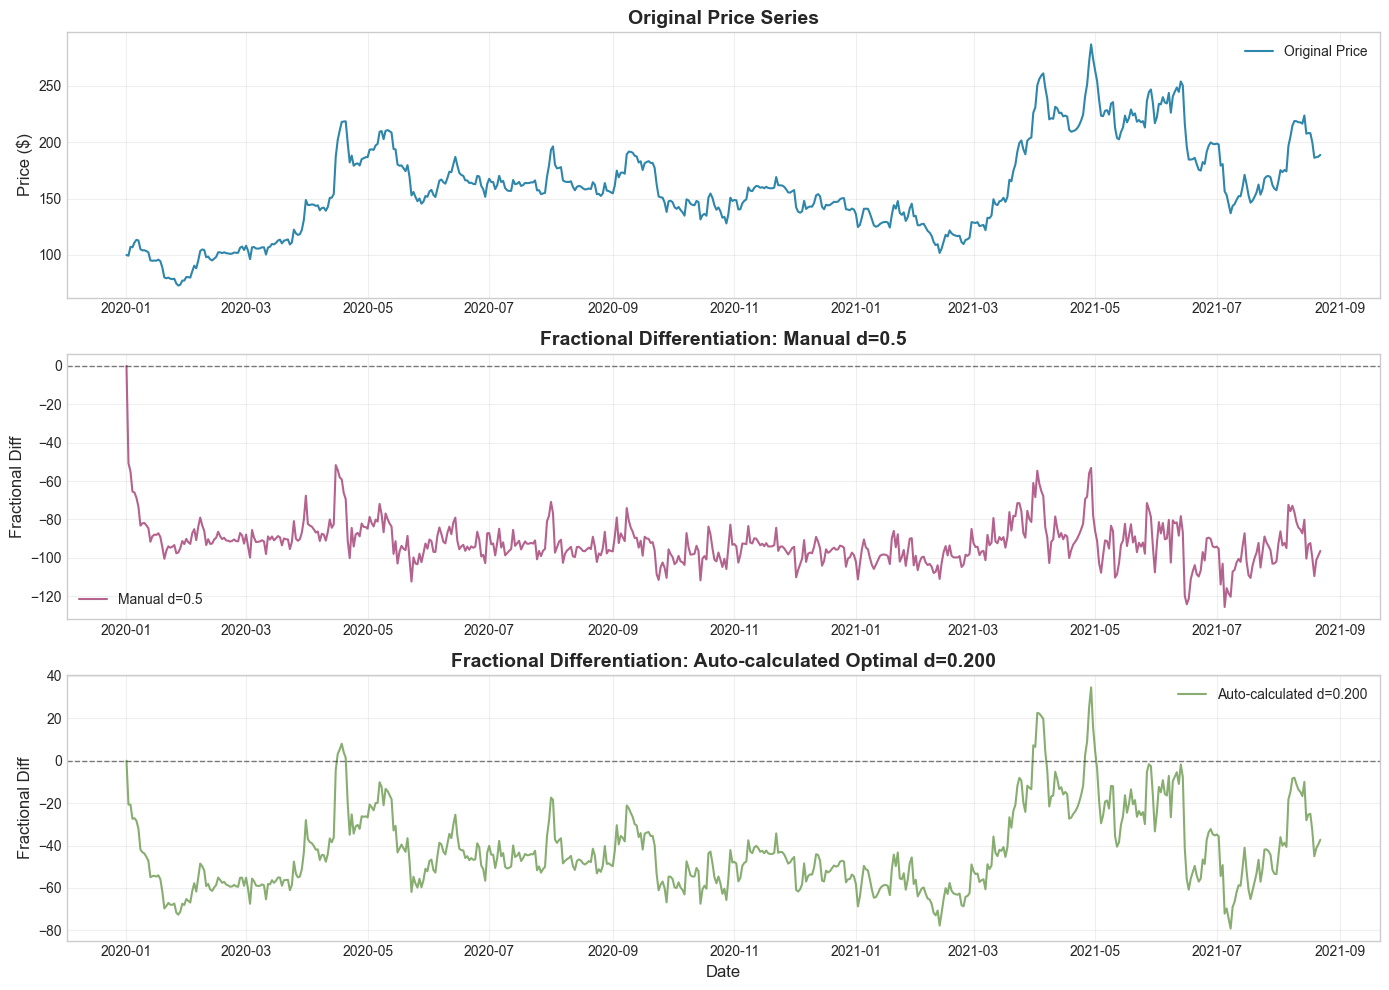


Example: Custom d_range for faster testing
With custom d_range [0.3, 0.4, 0.5, 0.6], optimal d found: 0.300


In [25]:
# Compare manual d vs auto-calculated optimal d

# Manual d = 0.5
rec_manual_d = recipe() \
    .step_fractional_diff(
        columns=['price'],
        d=0.5,  # Fixed d value
        threshold=1e-5,
        date_col='date',
        prefix='frac_diff_manual_'
    ) \
    .step_naomit(columns=['frac_diff_manual_price'])

# Auto-calculate optimal d
rec_auto_d = recipe() \
    .step_fractional_diff(
        columns=['price'],
        auto_d=True,  # Automatically find optimal d
        stationarity_test='adf',  # Use ADF test for stationarity
        alpha=0.05,  # 5% significance level
        threshold=1e-5,
        date_col='date',
        prefix='frac_diff_auto_'
    ) \
    .step_naomit(columns=['frac_diff_auto_price'])

# Prepare both recipes
prep_manual = rec_manual_d.prep(train_data)
prep_auto = rec_auto_d.prep(train_data)

# Get the optimal d value that was found
optimal_d = prep_auto.prepared_steps[0].d
print(f"Manual d value: 0.500")
print(f"Auto-calculated optimal d: {optimal_d:.3f}")
print(f"\nThe auto-calculated d={optimal_d:.3f} makes the series stationary while preserving more memory than d=0.5")

# Apply both transformations
train_manual = prep_manual.bake(train_data)
train_auto = prep_auto.bake(train_data)

# Compare results
print(f"\nComparison of fractional differentiation results:")
print("=" * 70)
print(f"{'Method':<25} {'Mean':<15} {'Std':<15} {'Min':<15} {'Max':<15}")
print("-" * 70)
print(f"{'Manual (d=0.5)':<25} {train_manual['frac_diff_manual_price'].mean():>14.6f} {train_manual['frac_diff_manual_price'].std():>14.6f} {train_manual['frac_diff_manual_price'].min():>14.6f} {train_manual['frac_diff_manual_price'].max():>14.6f}")
print(f"{'Auto (d=' + str(optimal_d) + ')':<25} {train_auto['frac_diff_auto_price'].mean():>14.6f} {train_auto['frac_diff_auto_price'].std():>14.6f} {train_auto['frac_diff_auto_price'].min():>14.6f} {train_auto['frac_diff_auto_price'].max():>14.6f}")

# Visualize comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original price
axes[0].plot(train_data['date'], train_data['price'], 
             linewidth=1.5, color='#2E86AB', label='Original Price')
axes[0].set_title('Original Price Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Manual d=0.5
axes[1].plot(train_manual['date'], train_manual['frac_diff_manual_price'], 
             linewidth=1.5, color='#A23B72', label=f'Manual d=0.5', alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_title('Fractional Differentiation: Manual d=0.5', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Fractional Diff', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Auto-calculated optimal d
axes[2].plot(train_auto['date'], train_auto['frac_diff_auto_price'], 
             linewidth=1.5, color='#6A994E', label=f'Auto-calculated d={optimal_d:.3f}', alpha=0.8)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[2].set_title(f'Fractional Differentiation: Auto-calculated Optimal d={optimal_d:.3f}', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Fractional Diff', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Example with custom d_range
print("\n" + "=" * 70)
print("Example: Custom d_range for faster testing")
print("=" * 70)
rec_custom_range = recipe() \
    .step_fractional_diff(
        columns=['price'],
        auto_d=True,
        d_range=[0.3, 0.4, 0.5, 0.6],  # Test only specific d values
        stationarity_test='adf',
        alpha=0.05,
        date_col='date',
        prefix='frac_diff_custom_'
    ) \
    .step_naomit(columns=['frac_diff_custom_price'])

prep_custom = rec_custom_range.prep(train_data)
optimal_d_custom = prep_custom.prepared_steps[0].d
print(f"With custom d_range [0.3, 0.4, 0.5, 0.6], optimal d found: {optimal_d_custom:.3f}")


## 9. Modeling with Financial ML Features

Let's create a workflow that uses these financial ML features to predict returns.


In [26]:
# Create workflow with financial ML recipe and linear regression
# Note: Recipe auto-generates formula, so we don't need to specify it
wf_finml = workflow() \
    .add_recipe(rec_finml) \
    .add_model(linear_reg())

# Fit workflow
fit_finml = wf_finml.fit(train_data)

# IMPORTANT: For time series features that require historical data (like fractional differentiation),
# we need to combine train and test data before prediction, so test data has access to training history.
# The workflow's predict() method will bake the data, so we pass the raw combined data.
# Then we filter predictions to only the test period.
combined_data = pd.concat([train_data, test_data], ignore_index=True).sort_values(by='date').reset_index(drop=True)

# Bake combined data to identify which rows remain after naomit
# This helps us align predictions with the correct dates
combined_baked = prep_finml.bake(combined_data)

# Make predictions on combined data (workflow will bake it internally)
all_predictions = fit_finml.predict(combined_data)

# Filter to only test period predictions
# Use the baked data to identify test rows (after naomit removed some rows)
test_date_mask = combined_baked['date'] >= test_data['date'].min()
predictions = all_predictions[test_date_mask.values].copy()

print(f"Combined data: {len(combined_data)} rows")
print(f"Combined data after transformation: {len(combined_baked)} rows")
print(f"Test predictions: {len(predictions)} rows")
print(f"Predictions shape: {predictions.shape}")

# Evaluate performance
outputs, coeffs, stats = fit_finml.extract_outputs()

display(outputs)
display(coeffs)
display(stats)

from py_visualize import plot_forecast, plot_residuals
fig = plot_forecast(fit_finml)
fig.show()


Combined data: 750 rows
Combined data after transformation: 691 rows
Test predictions: 150 rows
Predictions shape: (150, 1)


,date,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2020-01-01,104.424713,151.412241,104.424713,-46.987527,train,linear_reg,,global
1,2020-01-02,108.146629,136.085988,108.146629,-27.939359,train,linear_reg,,global
2,2020-01-03,103.733050,152.149040,103.733050,-48.415990,train,linear_reg,,global
3,2020-01-04,96.337871,148.808817,96.337871,-52.470947,train,linear_reg,,global
4,2020-01-05,106.728513,111.631293,106.728513,-4.902780,train,linear_reg,,global
...,...,...,...,...,...,...,...,...,...
536,2021-06-20,199.802666,197.203233,199.802666,2.599433,train,linear_reg,,global
537,2021-06-21,186.215564,181.017630,186.215564,5.197933,train,linear_reg,,global
538,2021-06-22,186.715809,174.131762,186.715809,12.584046,train,linear_reg,,global
539,2021-06-23,187.233850,182.456944,187.233850,4.776906,train,linear_reg,,global


,variable,coefficient,std_error,t_stat,p_value,vif,model,model_group_name,group,ci_0.025,ci_0.975
0,Intercept,-418.046622,72.501931,-5.766007,1.374629e-08,NaN,linear_reg,,global,-560.470601,-275.622642
1,returns,-471.808064,34.785952,-13.563178,0.000000e+00,1.865079,linear_reg,,global,-540.142158,-403.473971
2,volatility,-22.214157,54.565384,-0.407111,6.840897e-01,1.073188,linear_reg,,global,-129.403290,84.974976
3,frac_diff_price,3.202308,0.138078,23.191953,0.000000e+00,1.954564,linear_reg,,global,2.931065,3.473552
4,vol_ewm_returns,63.673873,129.537459,0.491548,6.232409e-01,1.204211,linear_reg,,global,-190.791630,318.139376
5,perm_entropy_returns,165.051559,62.212843,2.653014,8.215134e-03,1.032208,linear_reg,,global,42.839633,287.263486
6,weight,752.551148,42.907031,17.539110,0.000000e+00,1.141346,linear_reg,,global,668.263875,836.838421


,split,metric,value,model,model_group_name,group
0,train,rmse,23.137245,linear_reg,,global
1,train,mae,19.765725,linear_reg,,global
2,train,mape,12.661686,linear_reg,,global
3,train,smape,12.262366,linear_reg,,global
4,train,r_squared,0.596948,linear_reg,,global
5,train,mda,61.111111,linear_reg,,global
6,train,adj_r_squared,0.59242,linear_reg,,global
7,train,durbin_watson,0.182923,linear_reg,,global
8,train,shapiro_wilk_stat,0.980922,linear_reg,,global
9,train,shapiro_wilk_p,0.000002,linear_reg,,global


## 10. Visualize Predictions

Let's plot the actual vs predicted returns to see how well the model performs.

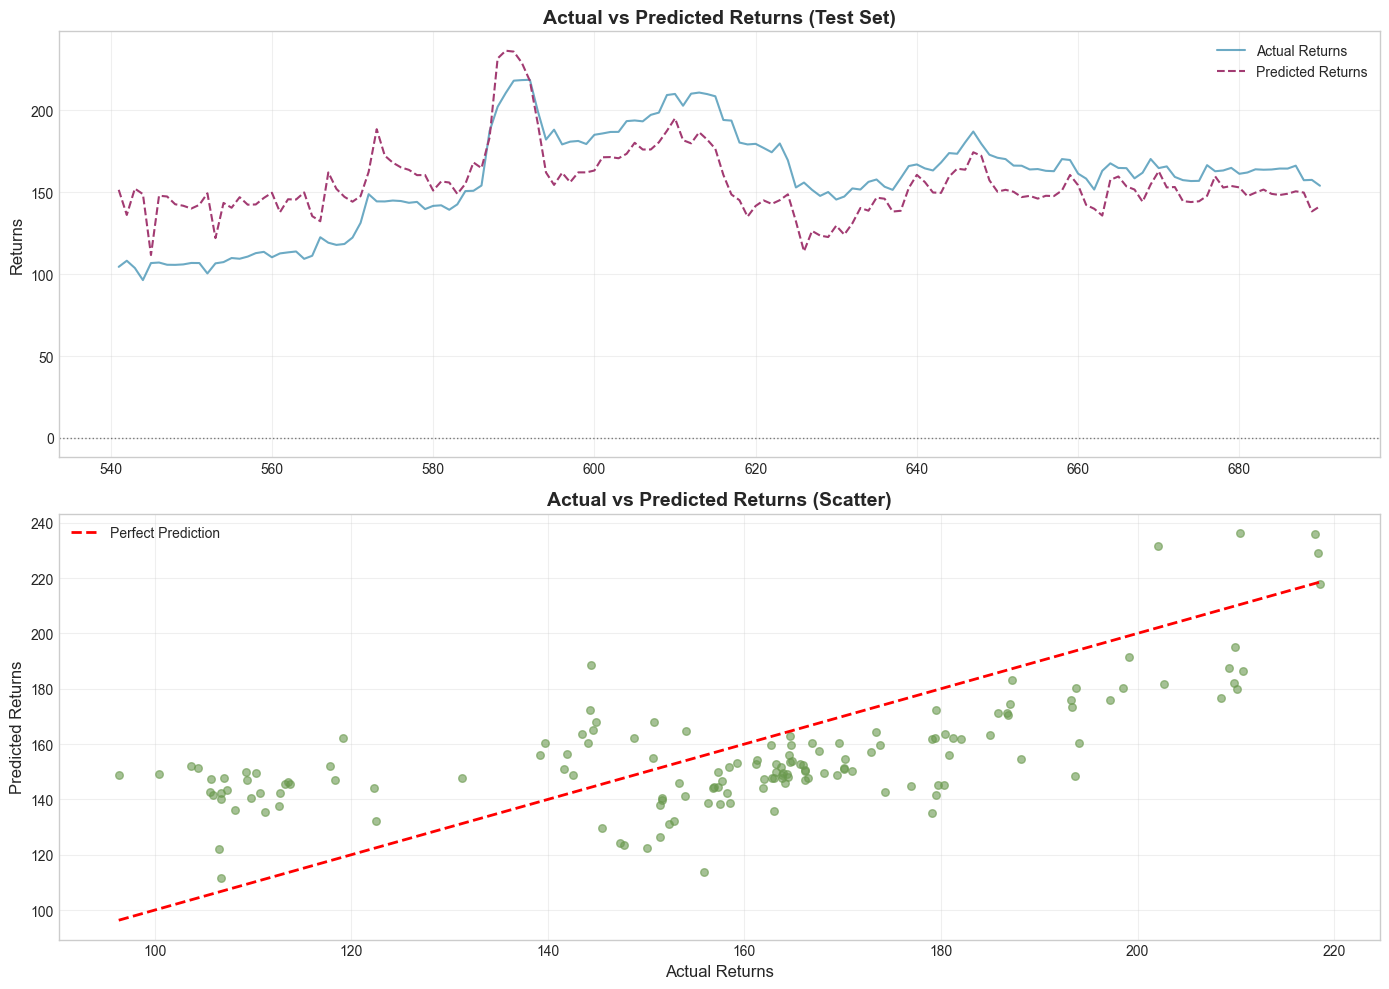


Test Set Performance:
  RMSE: 23.605915
  MAE: 20.785931
  R²: 0.3767


In [27]:
# Evaluate on test data
# We need to pass the combined data to evaluate, then filter results
# The evaluate method needs the outcome column (returns)
all_outputs, _, _ = fit_finml.evaluate(combined_data).extract_outputs()

# Filter outputs to only test period
# Use index positions from the mask to filter outputs
test_indices = np.where(test_date_mask.values)[0]
test_outputs = all_outputs.iloc[test_indices].copy()

# Plot predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Time series plot
axes[0].plot(test_outputs.index, test_outputs['actuals'], 
             label='Actual Returns', linewidth=1.5, color='#2E86AB', alpha=0.7)
axes[0].plot(test_outputs.index, test_outputs['fitted'], 
             label='Predicted Returns', linewidth=1.5, color='#A23B72', linestyle='--')
axes[0].axhline(y=0, color='black', linestyle=':', linewidth=1, alpha=0.5)
axes[0].set_title('Actual vs Predicted Returns (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Returns', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(test_outputs['actuals'], test_outputs['fitted'], 
                alpha=0.6, color='#6A994E', s=30)
axes[1].plot([test_outputs['actuals'].min(), test_outputs['actuals'].max()],
              [test_outputs['actuals'].min(), test_outputs['actuals'].max()],
              'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted Returns (Scatter)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Returns', fontsize=12)
axes[1].set_ylabel('Predicted Returns', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test set metrics
test_rmse = rmse(test_outputs['actuals'], test_outputs['fitted']).iloc[0]['value']
test_mae = mae(test_outputs['actuals'], test_outputs['fitted']).iloc[0]['value']
test_r2 = r_squared(test_outputs['actuals'], test_outputs['fitted']).iloc[0]['value']

print(f"\nTest Set Performance:")
print(f"  RMSE: {test_rmse:.6f}")
print(f"  MAE: {test_mae:.6f}")
print(f"  R²: {test_r2:.4f}")


## 11. Panel/Grouped Data Example

Financial ML steps support panel data (multiple time series) via the `group_col` parameter. This allows independent feature engineering for each group (e.g., different stocks).

In [28]:
# Generate data for multiple stocks
stocks = ['AAPL', 'GOOGL', 'MSFT']
panel_data_list = []

for stock in stocks:
    np.random.seed(42 + hash(stock) % 1000)  # Different seed per stock
    
    # Generate returns with stock-specific characteristics
    returns = np.random.normal(0.0005, 0.02, n_days)
    prices = 100 * np.exp(np.cumsum(returns))
    
    stock_data = pd.DataFrame({
        'date': dates,
        'ticker': stock,
        'price': prices,
        'returns': returns
    })
    panel_data_list.append(stock_data)

panel_data = pd.concat(panel_data_list, ignore_index=True)

print(f"Panel data shape: {panel_data.shape}")
print(f"Stocks: {panel_data['ticker'].unique()}")
panel_data.head(10)


Panel data shape: (2250, 4)
Stocks: ['AAPL' 'GOOGL' 'MSFT']


,date,ticker,price,returns
0,2020-01-01,AAPL,97.120671,-0.029216
1,2020-01-02,AAPL,97.073588,-0.000485
2,2020-01-03,AAPL,95.005447,-0.021535
3,2020-01-04,AAPL,98.533146,0.036459
4,2020-01-05,AAPL,97.295881,-0.012636
5,2020-01-06,AAPL,96.195728,-0.011372
6,2020-01-07,AAPL,93.359988,-0.029922
7,2020-01-08,AAPL,93.026364,-0.003580
8,2020-01-09,AAPL,94.103908,0.011517
9,2020-01-10,AAPL,92.952058,-0.012316


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/examples/../py_recipes/steps/financial_ml.py:326: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/examples/../py_recipes/steps/financial_ml.py:501: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/exampl

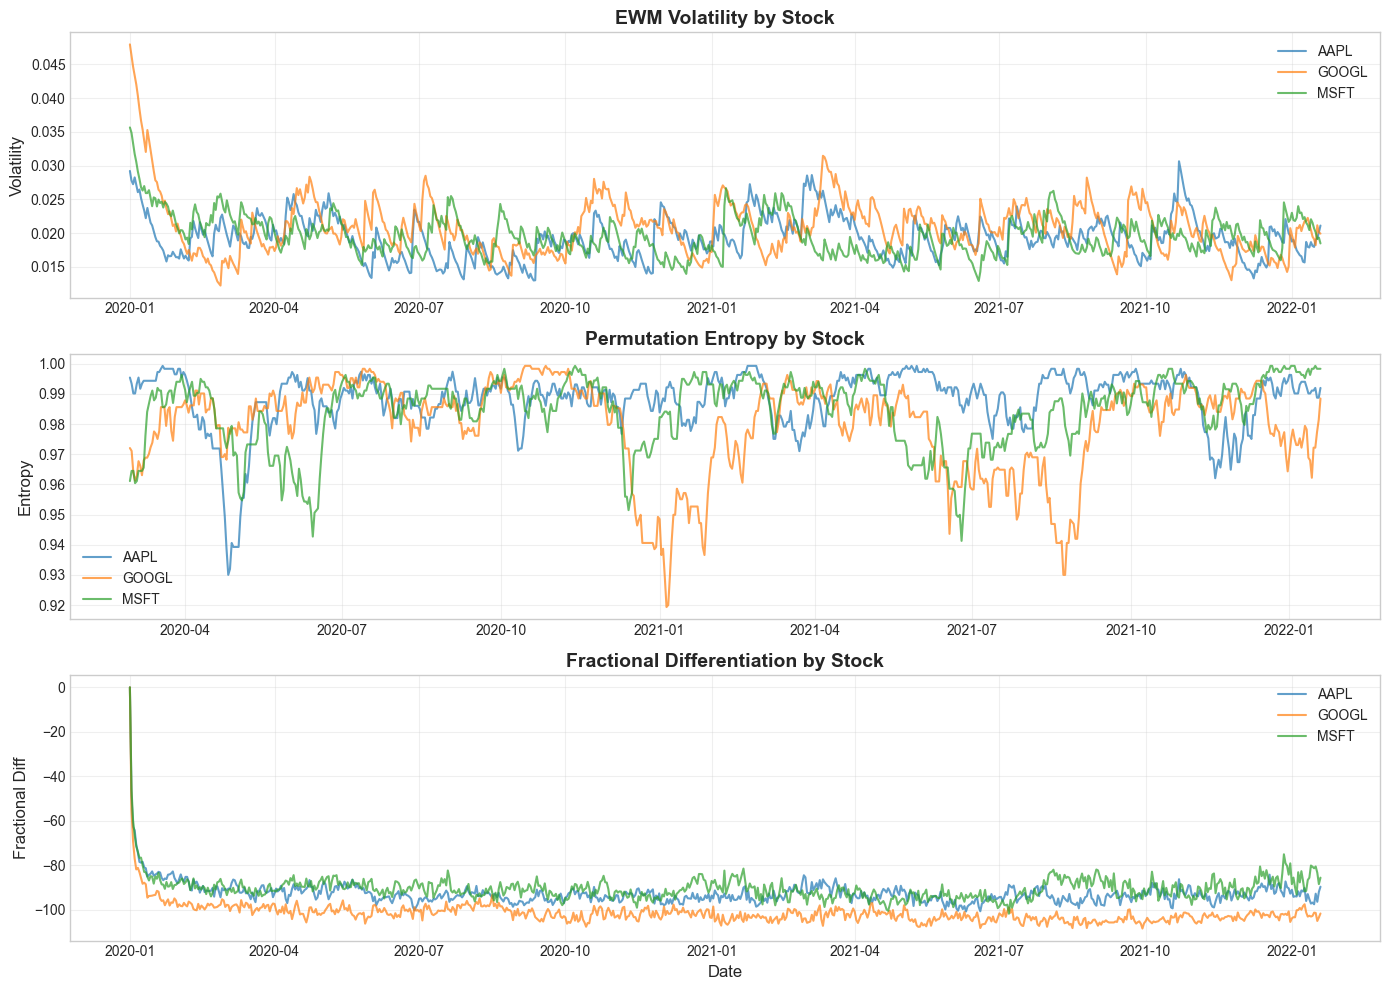


Panel data with financial ML features:
           date ticker       price   returns  vol_ewm_returns  \
0    2020-01-01   AAPL   97.120671 -0.029216         0.029216   
750  2020-01-01  GOOGL  104.912561  0.047957         0.047957   
1500 2020-01-01   MSFT   96.497009 -0.035658         0.035658   
1    2020-01-02   AAPL   97.073588 -0.000485         0.027790   
751  2020-01-02  GOOGL  102.324228 -0.024981         0.046263   
1501 2020-01-02   MSFT   99.072253  0.026337         0.034878   
2    2020-01-03   AAPL   95.005447 -0.021535         0.027256   
752  2020-01-03  GOOGL   99.839382 -0.024584         0.044654   
1502 2020-01-03   MSFT   98.172385 -0.009124         0.033295   
753  2020-01-04  GOOGL   97.093104 -0.027892         0.043338   
1503 2020-01-04   MSFT   97.524901 -0.006617         0.031735   
3    2020-01-04   AAPL   98.533146  0.036459         0.028262   
1504 2020-01-05   MSFT   96.006703 -0.015690         0.030572   
4    2020-01-05   AAPL   97.295881 -0.012636      

In [29]:
# Create recipe with grouped financial ML steps
rec_panel = recipe() \
    .step_fractional_diff(
        columns=['price'],
        d=0.5,
        date_col='date',
        group_col='ticker',  # Group by ticker
        prefix='frac_diff_'
    ) \
    .step_volatility_ewm(
        return_col='returns',
        span=20,
        date_col='date',
        group_col='ticker',  # Group by ticker
        prefix='vol_ewm_'
    ) \
    .step_permutation_entropy(
        columns=['returns'],
        window=60,
        order=3,
        date_col='date',
        group_col='ticker',  # Group by ticker
        prefix='perm_entropy_'
    )

# Prepare and bake
prep_panel = rec_panel.prep(panel_data)
panel_transformed = prep_panel.bake(panel_data)

# Visualize grouped features
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for i, stock in enumerate(stocks):
    stock_data = panel_transformed[panel_transformed['ticker'] == stock]
    
    axes[0].plot(stock_data['date'], stock_data['vol_ewm_returns'], 
                 label=stock, linewidth=1.5, alpha=0.7)
    axes[1].plot(stock_data['date'], stock_data['perm_entropy_returns'], 
                 label=stock, linewidth=1.5, alpha=0.7)
    axes[2].plot(stock_data['date'], stock_data['frac_diff_price'], 
                 label=stock, linewidth=1.5, alpha=0.7)

axes[0].set_title('EWM Volatility by Stock', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Volatility', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Permutation Entropy by Stock', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Entropy', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].set_title('Fractional Differentiation by Stock', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Fractional Diff', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPanel data with financial ML features:")
print(panel_transformed[['date', 'ticker', 'price', 'returns', 'vol_ewm_returns', 
                          'perm_entropy_returns', 'frac_diff_price']].head(15))


## Summary

This notebook demonstrated four financial machine learning recipe steps:

1. **StepFractionalDiff**: Transforms time series to be stationary while preserving long-term memory
2. **StepVolatilityEWM**: Calculates exponentially weighted moving volatility for responsive risk estimation
3. **StepPermutationEntropy**: Measures complexity and predictability of time series patterns
4. **StepWeightTimeDecay**: Applies time decay weighting to emphasize recent observations

### Key Takeaways:

- All steps support **panel/grouped data** via `group_col` parameter
- Steps can be **combined** in recipes for comprehensive feature engineering
- Steps integrate seamlessly with **workflows** for end-to-end modeling pipelines
- Financial ML features can improve model performance by capturing market microstructure

### Use Cases:

- **Algorithmic Trading**: Feature engineering for trading strategies
- **Risk Management**: Volatility estimation and regime detection
- **Portfolio Optimization**: Time decay weighting for adaptive models
- **Market Analysis**: Complexity measurement and pattern detection

### Next Steps:

- Experiment with different parameter values (d, span, order, decay_rate)
- Combine with other recipe steps (lag features, interactions, etc.)
- Use in nested workflows for panel/grouped modeling
- Apply to real financial data for production use
